In [1]:
%matplotlib inline
import sys
sys.path.append("/home/bianyuan/workspace/Grab_TNGgalaxy/")
# sys.path.append("./Grab_TNGgalaxy")
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sns
from tqdm import tqdm
from Project_galaxy import deIllustrisTNG_galaxy
import h5py
%matplotlib widget
run = 'TNG50'
basePath = '/media/bianyuan/data-TNG-1/' + run + '-1/output'
from astroML.plotting import setup_text_plots
#Lets text in plots use latex
setup_text_plots(usetex=True)

/home/bianyuan/.conda/envs/py310/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
'''Tranfer SnapNum to Redshift'''

import numpy as np
import h5py, scipy
from pynbody import units as units_conv

Redshift_snapshot = np.loadtxt('/home/bianyuan/workspace/data/Redshift_snapshot.txt',comments='Snapshot')

def redshift_snapshot(snapshots, datafile='/home/bianyuan/workspace/data/Redshift_snapshot.txt', return_opt=None):
    snapshots0, redshifts0 = np.loadtxt(datafile, skiprows=1, unpack=True, usecols=[0, 2])
    n_snap = np.size(snapshots)
    if n_snap == 1: 
        redshifts = redshifts0[np.where(snapshots0 == snapshots)][0]
    elif n_snap >1:
        redshifts = np.zeros(n_snap)
        for ii in range(n_snap): 
            if  snapshots[ii] is np.nan: 
                redshifts[ii] = np.nan
            else:
                redshifts[ii] = redshifts0[np.where(snapshots0 == snapshots[ii])][0]
    if return_opt is None: 
        return redshifts
#   elif return_opt == 'age':
#       return age(redshifts)
    elif return_opt == 'FT':
        return FT(redshifts)

def _a_dot(a, h0, om_m, om_l):                                
    om_k = 1.0 - om_m - om_l      
    return h0 * a * np.sqrt(om_m * (a ** -3) + om_k * (a ** -2) + om_l)  

def _a_dot_recip(*args):
    return 1. / _a_dot(*args) 

# The formation time of stars in unit of Gyr
def FT(redshift, h0=0.6774, OmegaM=0.3089, OmegaL=0.6911):
    conv = units_conv.Unit("0.01 s Mpc km^-1").ratio('Gyr')
    redshift = 1./(1. + redshift)
    ns = np.size(redshift)
    if ns > 1:
        FT = np.zeros(ns)
        for ii in range(ns): FT[ii] = scipy.integrate.quad(_a_dot_recip, 0, redshift[ii], (h0, OmegaM, OmegaL))[0] * conv
    else:
        FT = scipy.integrate.quad(_a_dot_recip, 0, redshift, (h0, OmegaM, OmegaL))[0] * conv
    return FT

In [3]:
Re = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloHalfmassRadType'])[:,4]

In [4]:
def element_save(subhalo_id,snap=99):
    H0 = 67.74
    h = H0/100.
    WM = 0.3089
    WV = 0.6911
    Tyr = 977.8
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV
    n=1000
    galaxy = deIllustrisTNG_galaxy(subhalo_id, deproject=True, align_with='star', radius_align_max=10., radius_align_min=0., centmode='pot', snapshot=snap, basePath=basePath, run=run)
    az = galaxy.s['tform'] #scale factor
    m = galaxy.s['mass']
    re = Re[subhalo_id]

    r = np.sqrt(galaxy.s['x']**2 + galaxy.s['y']**2 + galaxy.s['z']**2)

    age = 0.
    total_mass = sum(m)
    for j in range(n):
        a = az*(j+0.5)/n
        adot = (WK+(WM/a)+(WR/(a*a))+(WV*a*a))**0.5
        age = age + adot**(-1)

    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage #this is calculate age
    zage_LBT = FT(redshift_snapshot(99)) - zage_Gyr
    
    galaxydic={}
    galaxydic['age']=zage_LBT
    galaxydic['R']=r
    galaxydic['Re']= re
    return galaxydic

In [5]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
Normal_Dwarf = sns.load_dataset('Normal_Dwarf',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRY'''
MRY_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRY_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
# Iso_CSSs_4MRY = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.65))) ) )]
# Iso_ND_4MRY = np.array(Normal_Dwarf['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.65))) ) )]

with h5py.File('/home/bianyuan/workspace/data/MRY_grp_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MRY_grp_CSSs)) as pbar:
        for j in MRY_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                ddset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MRY_cl_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MRY_cl_CSSs)) as pbar:
        for j in MRY_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 71/71 [03:16<00:00,  2.77s/it]


In [19]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MP'''
MP_fl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] < 5) )]
MP_grp_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) )]
MP_cl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
# Iso_CSSs_4MP = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9))) ) )]
# Iso_ND_4MP = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9))) ) )]

with h5py.File('/home/bianyuan/workspace/data/MP_fl_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MP_fl_CSSs)) as pbar:
        for j in MP_fl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MP_grp_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MP_grp_CSSs)) as pbar:
        for j in MP_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MP_cl_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MP_cl_CSSs)) as pbar:
        for j in MP_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

100%|██████████| 39/39 [01:11<00:00,  1.85s/it]


In [6]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRO'''
MRO_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 6.4) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRO_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 6.4) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
with h5py.File('/home/bianyuan/workspace/data/MRO_grp_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MRO_grp_CSSs)) as pbar:
        for j in MRO_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MRO_cl_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MRO_cl_CSSs)) as pbar:
        for j in MRO_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 91/91 [03:10<00:00,  2.09s/it]


In [7]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRI'''
MRI_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRI_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
with h5py.File('/home/bianyuan/workspace/data/MRI_grp_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MRI_grp_CSSs)) as pbar:
        for j in MRI_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MRI_cl_R_n_age.hdf5', 'w') as f:
    with tqdm(total=len(MRI_cl_CSSs)) as pbar:
        for j in MRI_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j)
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('Re', data=galaxyd['Re'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 103/103 [04:32<00:00,  2.64s/it]


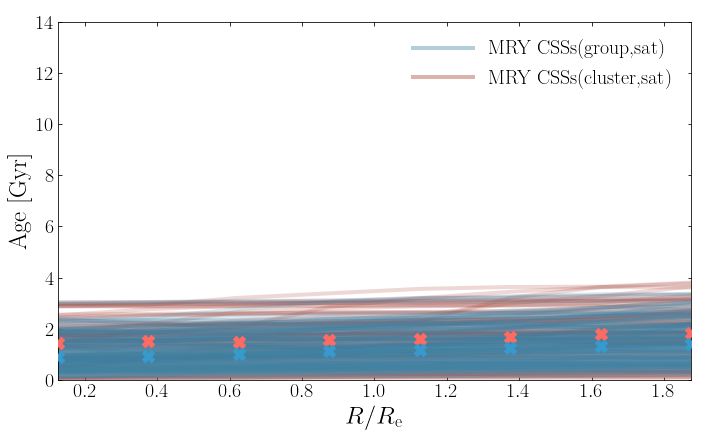

In [42]:
fl = (240/255,201/255,134/255,0.3)
# fl = 'yellow'
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)

bins=8

# Define the bin edges for the normalized R
bin_edges = np.linspace(0, 2, bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a new plot
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.08, bottom=0.12, right=0.96, top=0.95, wspace=0.15, hspace=0.07)

# List to store the median ages for all galaxies in each bin
global_median_ages = []

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MRY_cl_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=cl, alpha=0.2,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(255/255,106/255,99/255), marker='X', s=150, zorder=10)

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MRY_grp_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=grp, alpha=0.2 ,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(55/255,153/255,204/255), marker='X', s=150, zorder=10)

plt.plot([], [], color=grp, alpha=0.4 ,lw=4, label='MRY CSSs(group,sat)')
plt.plot([], [], color=cl, alpha=0.4 ,lw=4, label='MRY CSSs(cluster,sat)')

# Setting labels and title
plt.xlabel(r'$R/R_{\mathrm{e}}$',fontsize=25)
plt.ylabel('Age [Gyr]',fontsize=25,x=-4)
# plt.title('Median Age vs. Normalized R for different galaxies')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tick_params(axis='x', which='both', labelsize=20)
plt.tick_params(axis='y', which='both', labelsize=20)

# plt.xlim(0,2)
plt.ylim(0,14)

# Show a legend for reference (only for the first 5 galaxies to avoid overcrowding)
plt.rcParams['legend.fontsize'] = 20
plt.legend(frameon=False)

plt.savefig('/home/bianyuan/workspace/pic/Age_R_MRY.pdf')

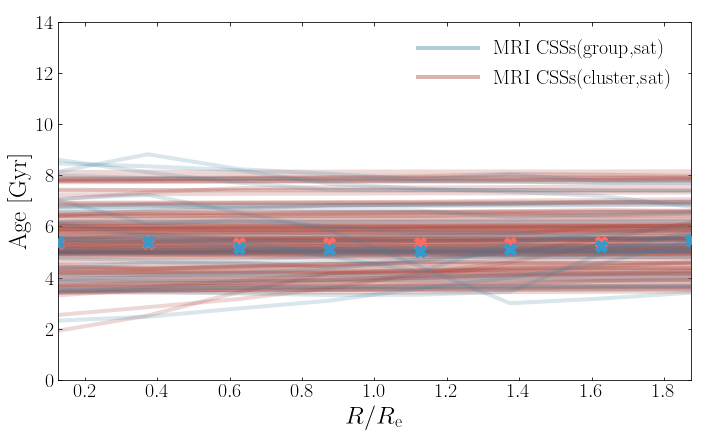

In [37]:
fl = (240/255,201/255,134/255,0.3)
# fl = 'yellow'
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)

bins=8

# Define the bin edges for the normalized R
bin_edges = np.linspace(0, 2, bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a new plot
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.08, bottom=0.12, right=0.96, top=0.95, wspace=0.15, hspace=0.07)

# List to store the median ages for all galaxies in each bin
global_median_ages = []

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MRI_cl_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=cl, alpha=0.2,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(255/255,106/255,99/255), marker='X', s=150, zorder=10)

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MRI_grp_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=grp, alpha=0.2 ,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(55/255,153/255,204/255), marker='X', s=150, zorder=10)

plt.plot([], [], color=grp, alpha=0.4 ,lw=4, label='MRI CSSs(group,sat)')
plt.plot([], [], color=cl, alpha=0.4 ,lw=4, label='MRI CSSs(cluster,sat)')

# Setting labels and title
plt.xlabel(r'$R/R_{\mathrm{e}}$',fontsize=25)
plt.ylabel('Age [Gyr]',fontsize=25,x=-4)
# plt.title('Median Age vs. Normalized R for different galaxies')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tick_params(axis='x', which='both', labelsize=20)
plt.tick_params(axis='y', which='both', labelsize=20)

# plt.xlim(0,2)
plt.ylim(0,14)

# Show a legend for reference (only for the first 5 galaxies to avoid overcrowding)
plt.rcParams['legend.fontsize'] = 20
plt.legend(frameon=False)

plt.savefig('/home/bianyuan/workspace/pic/Age_R_MRI.pdf')

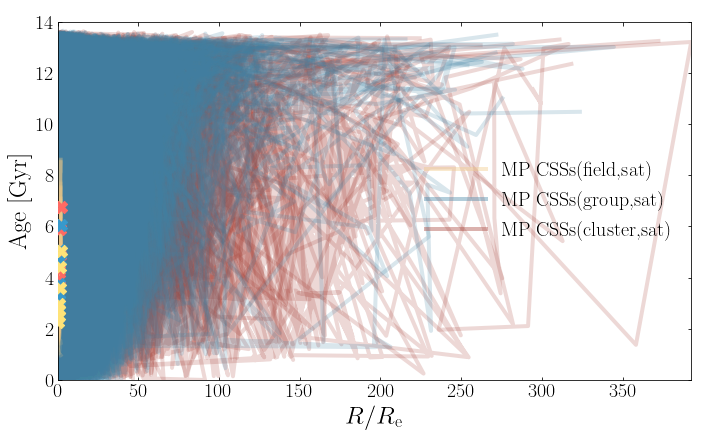

In [19]:
fl = (240/255,201/255,134/255,0.3)
# fl = 'yellow'
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)

bins=8

# Define the bin edges for the normalized R
bin_edges = np.linspace(0, 2, bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a new plot
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.08, bottom=0.12, right=0.96, top=0.95, wspace=0.15, hspace=0.07)

# List to store the median ages for all galaxies in each bin
global_median_ages = []

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MP_cl_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        # plt.plot(bin_centers, median_ages, color=cl, alpha=0.2,lw=4)  # Labeling the first 5 galaxies for reference
        plt.plot(normalized_R, age_data, color=cl, alpha=0.2,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(255/255,106/255,99/255), marker='X', s=150, zorder=10)

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MP_grp_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        # plt.plot(bin_centers, median_ages, color=grp, alpha=0.2 ,lw=4)  # Labeling the first 5 galaxies for reference
        plt.plot(normalized_R, age_data, color=grp, alpha=0.2,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(55/255,153/255,204/255), marker='X', s=150, zorder=10)


# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MP_fl_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=fl, alpha=0.2 ,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(255/255,227/255,120/255), marker='X', s=150, zorder=10)

plt.plot([], [], color=fl, alpha=0.4 ,lw=4, label='MP CSSs(field,sat)')
plt.plot([], [], color=grp, alpha=0.4 ,lw=4, label='MP CSSs(group,sat)')
plt.plot([], [], color=cl, alpha=0.4 ,lw=4, label='MP CSSs(cluster,sat)')

# Setting labels and title
plt.xlabel(r'$R/R_{\mathrm{e}}$',fontsize=25)
plt.ylabel('Age [Gyr]',fontsize=25,x=-4)
# plt.title('Median Age vs. Normalized R for different galaxies')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tick_params(axis='x', which='both', labelsize=20)
plt.tick_params(axis='y', which='both', labelsize=20)

# plt.xlim(0,2)
plt.ylim(0,14)

# Show a legend for reference (only for the first 5 galaxies to avoid overcrowding)
plt.rcParams['legend.fontsize'] = 20
plt.legend(frameon=False)

plt.savefig('/home/bianyuan/workspace/pic/Age_R_MP.pdf')

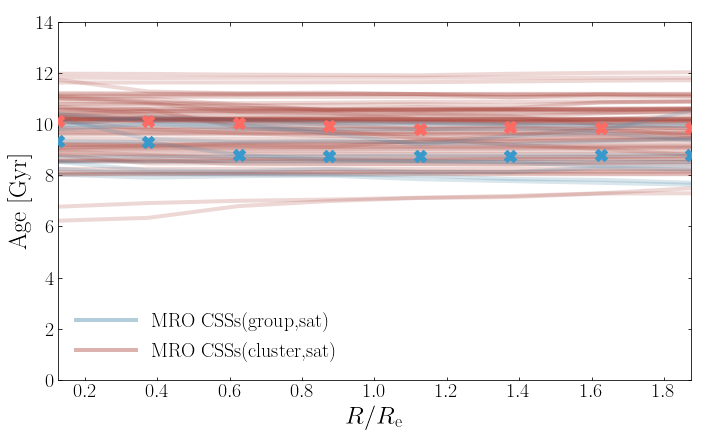

In [39]:
fl = (240/255,201/255,134/255,0.3)
# fl = 'yellow'
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)

bins=8

# Define the bin edges for the normalized R
bin_edges = np.linspace(0, 2, bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a new plot
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.08, bottom=0.12, right=0.96, top=0.95, wspace=0.15, hspace=0.07)

# List to store the median ages for all galaxies in each bin
global_median_ages = []

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MRO_cl_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=cl, alpha=0.2,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(255/255,106/255,99/255), marker='X', s=150, zorder=10)

# Loop over each galaxy ID to calculate median age for each bin and plot
with h5py.File("/home/bianyuan/workspace/data/MRO_grp_R_n_age.hdf5", 'r') as f:
    new_galaxy_ids = list(f.keys())
    for idx, galaxy_id in enumerate(new_galaxy_ids):
        age_data = f[galaxy_id]['age'][:]
        R_data = f[galaxy_id]['R'][:]
        R_e = f[galaxy_id]['Re'][()]  # Extracting the half-mass radius from the "Re" dataset
        
        # Normalize R values
        normalized_R = R_data / R_e

        # Filter data to keep only values within the range [0, 1.5]
        mask = (normalized_R >= 0) & (normalized_R <= 2)
        filtered_R = normalized_R[mask]
        filtered_age = age_data[mask]
        
        # Calculate median age for each bin
        median_ages = [np.median(filtered_age[(filtered_R >= bin_edges[i]) & (filtered_R < bin_edges[i+1])]) for i in range(bins)]
        
        # If this is the first galaxy, initialize the global_median_ages list
        if idx == 0:
            global_median_ages = [[] for _ in range(bins)]
        
        # Add the median ages to the global list for later calculation
        for i in range(bins):
            if not np.isnan(median_ages[i]):
                global_median_ages[i].append(median_ages[i])

        plt.plot(bin_centers, median_ages, color=grp, alpha=0.2 ,lw=4)  # Labeling the first 5 galaxies for reference

# Calculate the global median for each bin and plot it
global_medians = [np.median(ages) for ages in global_median_ages]
plt.scatter(bin_centers, global_medians, color=(55/255,153/255,204/255), marker='X', s=150, zorder=10)

plt.plot([], [], color=grp, alpha=0.4 ,lw=4, label='MRO CSSs(group,sat)')
plt.plot([], [], color=cl, alpha=0.4 ,lw=4, label='MRO CSSs(cluster,sat)')

# Setting labels and title
plt.xlabel(r'$R/R_{\mathrm{e}}$',fontsize=25)
plt.ylabel('Age [Gyr]',fontsize=25,x=-4)
# plt.title('Median Age vs. Normalized R for different galaxies')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tick_params(axis='x', which='both', labelsize=20)
plt.tick_params(axis='y', which='both', labelsize=20)

# plt.xlim(0,2)
plt.ylim(0,14)

# Show a legend for reference (only for the first 5 galaxies to avoid overcrowding)
plt.rcParams['legend.fontsize'] = 20
plt.legend(frameon=False)

plt.savefig('/home/bianyuan/workspace/pic/Age_R_MRO.pdf')

In [8]:
def element_radial_save(subhalo_id, bins, snap=99):
    H0 = 67.74
    h = H0/100.
    WM = 0.3089
    WV = 0.6911
    Tyr = 977.8
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV
    n=1000
    galaxy = deIllustrisTNG_galaxy(subhalo_id, deproject=True, align_with='star', radius_align_max=10., radius_align_min=0., centmode='pot', snapshot=snap, basePath=basePath, run=run)
    az = galaxy.s['tform'] #scale factor
    m = galaxy.s['mass']
    re = Re[subhalo_id]

    FeH_solar = 10**-4.5
    alphaFe_solar = (10**-3.57+10**-3.31+10**-4.49+10**-4.4+10**-4.07)/10**-4.5

    star = il.snapshot.loadSubhalo(basePath, snap, subhalo_id, 'star', fields=['Coordinates','GFM_Metals','GFM_Metallicity','Masses','SubfindDensity'])
    Fe = star['GFM_Metals'][:,8]
    C = star['GFM_Metals'][:,2]
    O = star['GFM_Metals'][:,4]
    Ne = star['GFM_Metals'][:,5]
    Mg = star['GFM_Metals'][:,6]
    Si = star['GFM_Metals'][:,7]
    H = star['GFM_Metals'][:,0]

    r = np.sqrt(galaxy.s['x']**2 + galaxy.s['y']**2 + galaxy.s['z']**2)
    normalized_R = r / re

    age = 0.
    for j in range(n):
        a = az*(j+0.5)/n
        adot = (WK+(WM/a)+(WR/(a*a))+(WV*a*a))**0.5
        age = age + adot**(-1)
    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage #this is calculate age
    zage_LBT = FT(redshift_snapshot(99)) - zage_Gyr
    
    # Define bin edges for normalized R
    bin_edges = np.linspace(0, 2, bins+1)
    
    # Placeholders for storing mass-weighted data
    mw_age = np.zeros(bins)
    mw_FeH = np.zeros(bins)
    mw_alphaFe = np.zeros(bins)

    for k in range(bins):
        # Indices of stars within the current bin
        indices = np.where((normalized_R >= bin_edges[k]) & (normalized_R < bin_edges[k+1]))
        
        # Masses of stars within the current bin
        m_bin = m[indices]
        
        # Calculate mass-weighted values for each bin
        if np.sum(m_bin) != 0:
            mw_age[k] = FT(redshift_snapshot(99)) - np.sum(zage_Gyr[indices] * m_bin) / np.sum(m_bin)
            mw_FeH[k] = np.log10(np.sum(m[indices]*(C[indices]+O[indices]+Ne[indices]+Mg[indices]+Si[indices])/Fe[indices])/np.sum(m_bin) / alphaFe_solar)
            mw_alphaFe[k] = np.log10(np.sum(m[indices]*(Fe[indices]/H[indices]))/np.sum(m_bin) / FeH_solar)

    galaxydic = {}
    galaxydic['R'] = bin_edges
    galaxydic['age'] = mw_age
    galaxydic['FeH'] = mw_FeH
    galaxydic['alphaFe'] = mw_alphaFe
    return galaxydic

In [23]:
# Define bin edges for normalized R
bin_edges = np.linspace(0, 2, 100+1)
bin_edges

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [28]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
Normal_Dwarf = sns.load_dataset('Normal_Dwarf',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRY'''
MRY_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRY_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]

j = MRY_grp_CSSs[0]

# galaxyd = element_radial_save(j,100)

with h5py.File('/home/bianyuan/workspace/data/MRY_grp_R.hdf5', 'w') as f:
    with open('/dev/null', 'w') as null_file:
        sys.stdout = null_file
        grp = f.create_group(str(j))
        galaxyd = element_radial_save(j,100)
        dset = grp.create_dataset('R', data=galaxyd['R'])
        dset = grp.create_dataset('age', data=galaxyd['age'])
        dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
        dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
        sys.stdout = sys.__stdout__
    f.close()

In [9]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
Normal_Dwarf = sns.load_dataset('Normal_Dwarf',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRY'''
MRY_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRY_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]

with h5py.File('/home/bianyuan/workspace/data/MRY_grp_R.hdf5', 'w') as f:
    with tqdm(total=len(MRY_grp_CSSs)) as pbar:
        for j in MRY_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MRY_cl_R.hdf5', 'w') as f:
    with tqdm(total=len(MRY_cl_CSSs)) as pbar:
        for j in MRY_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 71/71 [03:28<00:00,  2.93s/it]


In [ ]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MP'''
MP_fl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] < 5) )]
MP_grp_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) )]
MP_cl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]

j = MP_fl_CSSs[0]


with h5py.File('/home/bianyuan/workspace/data/MP_fl_R.hdf5', 'w') as f:
    with tqdm(total=len(MP_fl_CSSs)) as pbar:
        for j in MP_fl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

In [40]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MP'''
MP_fl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] < 5) )]
MP_grp_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) )]
MP_cl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
# Iso_CSSs_4MP = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9))) ) )]
# Iso_ND_4MP = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9))) ) )]

with h5py.File('/home/bianyuan/workspace/data/MP_fl_R.hdf5', 'w') as f:
    with tqdm(total=len(MP_fl_CSSs)) as pbar:
        for j in MP_fl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MP_grp_R.hdf5', 'w') as f:
    with tqdm(total=len(MP_grp_CSSs)) as pbar:
        for j in MP_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MP_cl_R.hdf5', 'w') as f:
    with tqdm(total=len(MP_cl_CSSs)) as pbar:
        for j in MP_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 39/39 [01:12<00:00,  1.86s/it]


In [10]:
'''MRI'''
MRI_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRI_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]

with h5py.File('/home/bianyuan/workspace/data/MRI_grp_R.hdf5', 'w') as f:
    with tqdm(total=len(MRI_grp_CSSs)) as pbar:
        for j in MRI_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MRI_cl_R.hdf5', 'w') as f:
    with tqdm(total=len(MRI_cl_CSSs)) as pbar:
        for j in MRI_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 103/103 [04:50<00:00,  2.82s/it]


In [11]:
'''MRO'''
MRO_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 6.4) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRO_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 6.4) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.085) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]

with h5py.File('/home/bianyuan/workspace/data/MRO_grp_R.hdf5', 'w') as f:
    with tqdm(total=len(MRO_grp_CSSs)) as pbar:
        for j in MRO_grp_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/MRO_cl_R.hdf5', 'w') as f:
    with tqdm(total=len(MRO_cl_CSSs)) as pbar:
        for j in MRO_cl_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

100%|██████████| 92/92 [03:26<00:00,  2.25s/it]


In [38]:
'''iso'''
Iso_CSSs = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Distance_grpvir'] == 0) ) )]

with h5py.File('/home/bianyuan/workspace/data/Iso_R.hdf5', 'w') as f:
    with tqdm(total=len(Iso_CSSs)) as pbar:
        for j in Iso_CSSs:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_radial_save(j,100)
                dset = grp.create_dataset('R', data=galaxyd['R'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  7%|▋         | 22/332 [00:52<12:29,  2.42s/it]/home/bianyuan/.local/lib/python3.10/site-packages/pynbody/array.py:470: RuntimeWarning: invalid value encountered in power
  r = np.asarray(np.power(self.view(np.ndarray), numerical_x)).view(SimArray)
100%|██████████| 332/332 [10:04<00:00,  1.82s/it]


In [78]:
import h5py
def read_hdf5(para,path):
    # 打开 HDF5 文件
    file_path = path
    with h5py.File(file_path, 'r') as hdf5_file:
        # 获取组的数量
        num_groups= len(hdf5_file.keys())
        # 获取最长数据集的长度
        max_length = max(len(group[str(para)]) for group in hdf5_file.values())

        # 初始化空列表
        p_data = np.zeros((num_groups, 100))

        # 遍历组
        for i, group_name in enumerate(hdf5_file.keys()):
            group = hdf5_file[group_name]
            if isinstance(group, h5py.Group):
                p_dataset = np.nan_to_num(group[str(para)])
                p_data[i, :] =  p_dataset
    return p_data

path_MP_fl = '/home/bianyuan/workspace/data/MP_fl_R.hdf5'
path_MP_grp = '/home/bianyuan/workspace/data/MP_grp_R.hdf5'
path_MP_cl = '/home/bianyuan/workspace/data/MP_cl_R.hdf5'
path_MRY_grp = '/home/bianyuan/workspace/data/MRY_grp_R.hdf5'
path_MRY_cl = '/home/bianyuan/workspace/data/MRY_cl_R.hdf5'
path_MRI_grp = '/home/bianyuan/workspace/data/MRI_grp_R.hdf5'
path_MRI_cl = '/home/bianyuan/workspace/data/MRI_cl_R.hdf5'
path_MRO_grp = '/home/bianyuan/workspace/data/MRO_grp_R.hdf5'
path_MRO_cl = '/home/bianyuan/workspace/data/MRO_cl_R.hdf5'
path_iso = '/home/bianyuan/workspace/data/Iso_R.hdf5'

age_iso = read_hdf5('age',path_iso)
age_MP_fl = read_hdf5('age',path_MP_fl)
age_MP_grp = read_hdf5('age',path_MP_grp)
age_MP_cl = read_hdf5('age',path_MP_cl)
age_MRY_grp = read_hdf5('age',path_MRY_grp)
age_MRY_cl = read_hdf5('age',path_MRY_cl)
age_MRI_grp = read_hdf5('age',path_MRI_grp)
age_MRI_cl = read_hdf5('age',path_MRI_cl)
age_MRO_grp = read_hdf5('age',path_MRO_grp)
age_MRO_cl = read_hdf5('age',path_MRO_cl)

FeH_iso = read_hdf5('alphaFe',path_iso)
FeH_MP_fl = read_hdf5('alphaFe',path_MP_fl)
FeH_MP_grp = read_hdf5('alphaFe',path_MP_grp)
FeH_MP_cl = read_hdf5('alphaFe',path_MP_cl)
FeH_MRY_grp = read_hdf5('alphaFe',path_MRY_grp)
FeH_MRY_cl = read_hdf5('alphaFe',path_MRY_cl)
FeH_MRI_grp = read_hdf5('alphaFe',path_MRI_grp)
FeH_MRI_cl = read_hdf5('alphaFe',path_MRI_cl)
FeH_MRO_grp = read_hdf5('alphaFe',path_MRO_grp)
FeH_MRO_cl = read_hdf5('alphaFe',path_MRO_cl)

alphaFe_iso = read_hdf5('FeH',path_iso)
alphaFe_MP_fl = read_hdf5('FeH',path_MP_fl)
alphaFe_MP_grp = read_hdf5('FeH',path_MP_grp)
alphaFe_MP_cl = read_hdf5('FeH',path_MP_cl)
alphaFe_MRY_grp = read_hdf5('FeH',path_MRY_grp)
alphaFe_MRY_cl = read_hdf5('FeH',path_MRY_cl)
alphaFe_MRI_grp = read_hdf5('FeH',path_MRI_grp)
alphaFe_MRI_cl = read_hdf5('FeH',path_MRI_cl)
alphaFe_MRO_grp = read_hdf5('FeH',path_MRO_grp)
alphaFe_MRO_cl = read_hdf5('FeH',path_MRO_cl)

In [79]:
# Concatenate the arrays along the rows
combined_array = np.concatenate((age_iso, age_MP_fl, age_MP_grp, age_MP_cl, age_MRO_grp, age_MRO_cl, age_MRI_grp, age_MRI_cl), axis=0)
# combined_array = np.nan_to_num(combined_array, nan=1e-5)

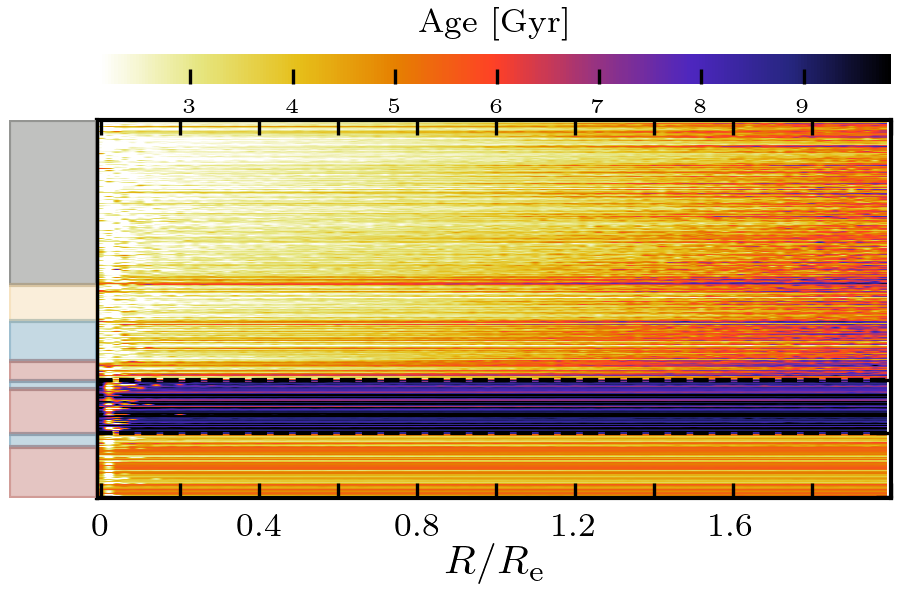

In [80]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

cmap = plt.get_cmap("CMRmap_r")
# cmap = plt.get_cmap("RdBu")
# cmap = plt.get_cmap("tab20b")
trunc_cmap = truncate_colormap(cmap, 0, 1)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have already obtained the combined_array

# Define the number of bins for rows and columns
row_bins = combined_array.shape[0]  # Number of rows in combined_array
col_bins = combined_array.shape[1]  # Number of columns in combined_array

# Create a heatmap plot
fig = plt.figure(figsize=(3, 2), dpi=300, facecolor='none')
plt.subplots_adjust(left=0.01, bottom=0.17, right=0.99, top=0.80)
grid = plt.GridSpec(6, 10, hspace=0, wspace=0)

# 添加子图
ax_main = fig.add_subplot(grid[:, 1:])
ax_left = fig.add_subplot(grid[:, 0], xticklabels=[], yticklabels=[])

ax_left.spines['bottom'].set_visible(False)
ax_left.spines['right'].set_visible(1)
ax_left.spines['top'].set_visible(False)
ax_left.spines['left'].set_visible(False)
ax_main.spines['left'].set_linewidth(1)  # 修改左边轴线宽度
ax_main.spines['bottom'].set_linewidth(1)  # 修改底部轴线宽度
ax_main.spines['top'].set_linewidth(1)  # 修改顶部轴线宽度
ax_main.spines['right'].set_linewidth(1)  # 修改右部轴线宽度

valid_values = combined_array[~np.isnan(combined_array) & ~np.isinf(combined_array)]
quantile_90 = np.percentile(valid_values, 95)
quantile_10 = np.percentile(valid_values, 5)

norm = mcolors.Normalize(vmin=quantile_10, vmax=quantile_90)
# norm = mcolors.Normalize(vmin=0, vmax=14)
# norm = mcolors.Normalize(vmin=0, vmax=0.05)
sc = ax_main.imshow(combined_array, cmap=trunc_cmap, aspect='auto', norm=norm)

# 分割的份数和每种颜色对应的范围
fl = (240/255,201/255,134/255,0.3)
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)
Iso_CSSs = (49/255,50/255,44/255,0.3)
# splits = [42, 10, 48, 21, 53, 133, 39, 78, 73, 332]
# colors = [cl, grp, cl, grp, cl, grp, cl, grp, fl, Iso_CSSs]

splits = [332, 73, 80, 39, 16, 91, 26, 103]
colors = [Iso_CSSs, fl, grp, cl, grp, cl, grp, cl]

# 计算每种颜色的范围
ranges = np.cumsum(splits)

# 绘制水平填充区域
start = len(splits)
for i in range(len(ranges)):
    end = start - splits[i]
    color = colors[i]
    ax_left.axhspan(end, start, color=color)
    start = end

splits = [524, 107, 129]
labels = ['MPs', 'MROs', 'MRIs']

# 计算每种颜色的范围
ranges = np.cumsum(splits)

# # 绘制水平填充区域并添加文字
# start = len(splits)
# for i in range(len(ranges)):
#     end = start - splits[i]
#     label = labels[i]
#     ax_left.text(0.5, (start + end) / 2, label, ha='center', va='center', rotation='vertical',fontsize=8)
#     start = end

# 设置子图的刻度和标签
ax_left.set_xticks([])
# ax_left.set_yticks(range(len(splits)))
ax_left.set_yticks([])
ax_left.set_yticklabels([])

# Set the row and column bin labels
# plt.xticks(np.arange(0, col_bins, 1))
# ax_main.set_xticks(np.arange(0, col_bins, 1))
# ax_main.set_xticks([])

# ax_main.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
# ax_main.set_xticklabels([0, '', '', '3', '', '', '6', '', '', '9', '', '', '12', '']) # , rotation=90
# ax_main.set_xlim(0,1200)
ax_main.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_main.set_xticklabels(['0', '', '0.4', '', '0.8', '', '1.2', '', '1.6', '', '']) # , rotation=90
# ax_main.set_xlim(0,60)

ax_main.set_yticks([524, 631, 760])
ax_main.set_yticklabels(['', '', '']) # , rotation=90

line_positions = [524, 631]
# 在指定刻度处绘制黑色实线
for pos in line_positions:
    ax_main.axhline(pos, color='black', linestyle='--', linewidth=1)

# Add colorbar
# cbar = fig.colorbar(sc, ax=ax_main, pad=0.05)
# cbar.set_label('Age [Gyr]',fontsize=15)
# cbar.ax.tick_params(labelsize=15)
# cbar.outline.set_visible(False)

cbar_ax = fig.add_axes([0.11, 0.86, 0.88, 0.05])  # Adjust the position and size as needed
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Age [Gyr]', fontsize=8, labelpad=5)
cbar.ax.tick_params(labelsize=5)
cbar.outline.set_visible(False)

# Move colorbar label above the colorbar
cbar.ax.xaxis.set_label_position('top')

# cbar.ax.set_size(0.05)
# cbar.outline.set_linewidth(2)
ax_main.set_xlabel(r'$R/R_{\mathrm{e}}$', fontsize=10, labelpad=0)
# ax_main.set_ylabel('[Z/H]', fontsize=20)
ax_main.tick_params(axis='both', which='major', labelsize=8)

plt.savefig('/home/bianyuan/workspace/pic/age_R.pdf')

In [81]:
import h5py
def read_hdf5(para,path):
    # 打开 HDF5 文件
    file_path = path
    with h5py.File(file_path, 'r') as hdf5_file:
        # 获取组的数量
        num_groups= len(hdf5_file.keys())
        # 获取最长数据集的长度
        max_length = max(len(group[str(para)]) for group in hdf5_file.values())

        # 初始化空列表
        p_data = np.zeros((num_groups, 100))

        # 遍历组
        for i, group_name in enumerate(hdf5_file.keys()):
            group = hdf5_file[group_name]
            if isinstance(group, h5py.Group):
                p_dataset = np.nan_to_num(group[str(para)])
                p_data[i, :] =  p_dataset
    return p_data

path_MP_fl = '/home/bianyuan/workspace/data/MP_fl_R.hdf5'
path_MP_grp = '/home/bianyuan/workspace/data/MP_grp_R.hdf5'
path_MP_cl = '/home/bianyuan/workspace/data/MP_cl_R.hdf5'
path_MRY_grp = '/home/bianyuan/workspace/data/MRY_grp_R.hdf5'
path_MRY_cl = '/home/bianyuan/workspace/data/MRY_cl_R.hdf5'
path_MRI_grp = '/home/bianyuan/workspace/data/MRI_grp_R.hdf5'
path_MRI_cl = '/home/bianyuan/workspace/data/MRI_cl_R.hdf5'
path_MRO_grp = '/home/bianyuan/workspace/data/MRO_grp_R.hdf5'
path_MRO_cl = '/home/bianyuan/workspace/data/MRO_cl_R.hdf5'
path_iso = '/home/bianyuan/workspace/data/Iso_R.hdf5'

FeH_iso = read_hdf5('alphaFe',path_iso)
FeH_MP_fl = read_hdf5('alphaFe',path_MP_fl)
FeH_MP_grp = read_hdf5('alphaFe',path_MP_grp)
FeH_MP_cl = read_hdf5('alphaFe',path_MP_cl)
FeH_MRY_grp = read_hdf5('alphaFe',path_MRY_grp)
FeH_MRY_cl = read_hdf5('alphaFe',path_MRY_cl)
FeH_MRI_grp = read_hdf5('alphaFe',path_MRI_grp)
FeH_MRI_cl = read_hdf5('alphaFe',path_MRI_cl)
FeH_MRO_grp = read_hdf5('alphaFe',path_MRO_grp)
FeH_MRO_cl = read_hdf5('alphaFe',path_MRO_cl)

alphaFe_iso = read_hdf5('FeH',path_iso)
alphaFe_MP_fl = read_hdf5('FeH',path_MP_fl)
alphaFe_MP_grp = read_hdf5('FeH',path_MP_grp)
alphaFe_MP_cl = read_hdf5('FeH',path_MP_cl)
alphaFe_MRY_grp = read_hdf5('FeH',path_MRY_grp)
alphaFe_MRY_cl = read_hdf5('FeH',path_MRY_cl)
alphaFe_MRI_grp = read_hdf5('FeH',path_MRI_grp)
alphaFe_MRI_cl = read_hdf5('FeH',path_MRI_cl)
alphaFe_MRO_grp = read_hdf5('FeH',path_MRO_grp)
alphaFe_MRO_cl = read_hdf5('FeH',path_MRO_cl)

In [69]:
combined_array = np.concatenate((FeH_iso, FeH_MP_fl, FeH_MP_grp, FeH_MP_cl, FeH_MRO_grp, FeH_MRO_cl, FeH_MRI_grp, FeH_MRI_cl), axis=0)

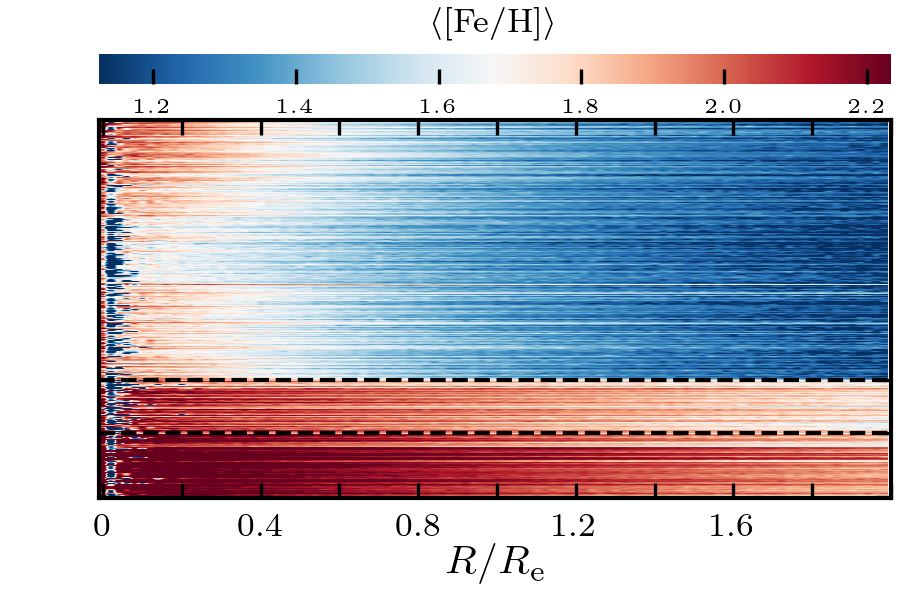

In [77]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

cmap = plt.get_cmap("RdBu_r")
# cmap = plt.get_cmap("RdBu")
# cmap = plt.get_cmap("tab20b")
trunc_cmap = truncate_colormap(cmap, 0, 1)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have already obtained the combined_array

# Define the number of bins for rows and columns
row_bins = combined_array.shape[0]  # Number of rows in combined_array
col_bins = combined_array.shape[1]  # Number of columns in combined_array

# Create a heatmap plot
# fig = plt.figure(figsize=(6, 10), dpi=160, facecolor='white')
# plt.subplots_adjust(left=0.08, bottom=0.08, right=0.88, top=0.98)
fig = plt.figure(figsize=(3, 2), dpi=300, facecolor='none')
# plt.subplots_adjust(left=0.1, bottom=0.08, right=0.88, top=0.88)
# grid = plt.GridSpec(6, 10, hspace=0, wspace=0)

plt.subplots_adjust(left=0.11, bottom=0.17, right=0.99, top=0.80)

# Create main subplot for the heatmap
ax_main = fig.add_subplot(111)

# 添加子图
# ax_main = fig.add_subplot(grid[:, 1:])
# ax_left = fig.add_subplot(grid[:, 0], xticklabels=[], yticklabels=[])

# ax_left.spines['bottom'].set_visible(False)
# ax_left.spines['right'].set_visible(1)
# ax_left.spines['top'].set_visible(False)
# ax_left.spines['left'].set_visible(False)
ax_main.spines['left'].set_linewidth(1)  # 修改左边轴线宽度
ax_main.spines['bottom'].set_linewidth(1)  # 修改底部轴线宽度
ax_main.spines['top'].set_linewidth(1)  # 修改顶部轴线宽度
ax_main.spines['right'].set_linewidth(1)  # 修改右部轴线宽度

valid_values = combined_array[~np.isnan(combined_array) & ~np.isinf(combined_array)]
quantile_90 = np.percentile(valid_values, 95)
quantile_10 = np.percentile(valid_values, 5)

norm = mcolors.Normalize(vmin=quantile_10, vmax=quantile_90)
# norm = mcolors.Normalize(vmin=0, vmax=14)
# norm = mcolors.Normalize(vmin=0, vmax=0.05)
sc = ax_main.imshow(combined_array, cmap=trunc_cmap, aspect='auto', norm=norm)

# 分割的份数和每种颜色对应的范围
fl = (240/255,201/255,134/255,0.3)
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)
Iso_CSSs = (49/255,50/255,44/255,0.3)
# splits = [42, 10, 48, 21, 53, 133, 39, 78, 73, 332]
# colors = [cl, grp, cl, grp, cl, grp, cl, grp, fl, Iso_CSSs]

splits = [332, 73, 80, 39, 16, 91, 26, 103]
colors = [Iso_CSSs, fl, grp, cl, grp, cl, grp, cl]

# 计算每种颜色的范围
ranges = np.cumsum(splits)

# 绘制水平填充区域
start = len(splits)
for i in range(len(ranges)):
    end = start - splits[i]
    color = colors[i]
    ax_left.axhspan(end, start, color=color)
    start = end

splits = [524, 107, 129]
labels = ['MPs', 'MROs', 'MRI']

# 计算每种颜色的范围
ranges = np.cumsum(splits)

# 绘制水平填充区域并添加文字
start = len(splits)
for i in range(len(ranges)):
    end = start - splits[i]
    label = labels[i]
    ax_left.text(0.5, (start + end) / 2, label, ha='center', va='center', rotation='vertical',fontsize=15)
    start = end

# 设置子图的刻度和标签
# ax_left.set_xticks([])
# # ax_left.set_yticks(range(len(splits)))
# ax_left.set_yticks([])
# ax_left.set_yticklabels([])

# Set the row and column bin labels
# plt.xticks(np.arange(0, col_bins, 1))
# ax_main.set_xticks(np.arange(0, col_bins, 1))
# ax_main.set_xticks([])

# ax_main.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
# ax_main.set_xticklabels([0, '', '', '3', '', '', '6', '', '', '9', '', '', '12', '']) # , rotation=90
# ax_main.set_xlim(0,1200)
ax_main.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_main.set_xticklabels(['0', '', '0.4', '', '0.8', '', '1.2', '', '1.6', '', '']) # , rotation=90
# ax_main.set_xlim(0,60)

ax_main.set_yticks([524, 631, 760])
ax_main.set_yticklabels(['', '', '']) # , rotation=90

line_positions = [524, 631]
# 在指定刻度处绘制黑色实线
for pos in line_positions:
    ax_main.axhline(pos, color='black', linestyle='--', linewidth=1)

# Add colorbar
# cbar = fig.colorbar(sc, ax=ax_main, pad=0.05)
# cbar.set_label(r'$\left \langle[\mathrm{Fe/H}]\right \rangle$',fontsize=15)
# cbar.ax.tick_params(labelsize=15)
# cbar.outline.set_visible(False)

cbar_ax = fig.add_axes([0.11, 0.86, 0.88, 0.05])  # Adjust the position and size as needed

cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$\left \langle[\mathrm{Fe/H}]\right \rangle$', fontsize=8, labelpad=5)
cbar.ax.tick_params(labelsize=5)
cbar.outline.set_visible(False)

# Move colorbar label above the colorbar
cbar.ax.xaxis.set_label_position('top')

# cbar.ax.set_size(0.05)
# cbar.outline.set_linewidth(2)
ax_main.set_xlabel(r'$R/R_{\mathrm{e}}$', fontsize=10, labelpad=0)
# ax_main.set_ylabel('[Z/H]', fontsize=20)
ax_main.tick_params(axis='both', which='major', labelsize=8)

plt.savefig('/home/bianyuan/workspace/pic/FeH_R.pdf')

In [82]:
combined_array = np.concatenate((alphaFe_iso, alphaFe_MP_fl, alphaFe_MP_grp, alphaFe_MP_cl, alphaFe_MRO_grp, alphaFe_MRO_cl, alphaFe_MRI_grp, alphaFe_MRI_cl), axis=0)

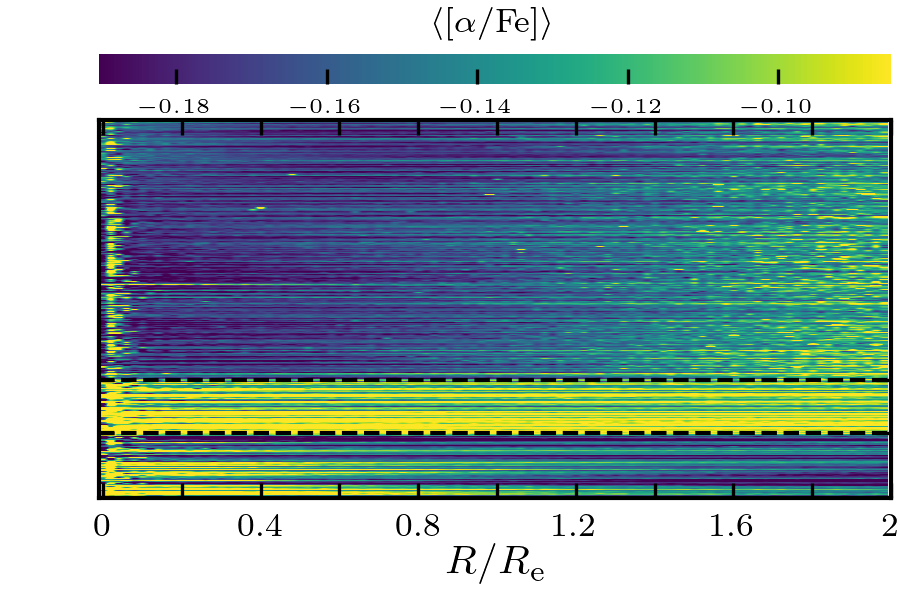

In [84]:
import colorsys
import matplotlib.colors as mcolors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

def adjust_saturation(cmap, scale_factor):
    """Adjust the saturation of a colormap."""
    colors = cmap(np.linspace(0, 1, cmap.N))
    
    # Convert RGB to HSV
    hsv_colors = [colorsys.rgb_to_hsv(color[0], color[1], color[2]) for color in colors]
    
    # Reduce saturation
    hsv_colors = [(h, s*scale_factor, v) for h, s, v in hsv_colors]
    
    # Convert back to RGB
    rgb_colors = [colorsys.hsv_to_rgb(h, s, v) for h, s, v in hsv_colors]
    
    # Create new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("", rgb_colors)
    
    return new_cmap

# Get the jet colormap
jet = plt.get_cmap("jet")

# Reduce its saturation by 50%
desaturated_jet = adjust_saturation(jet, 0.5)
cmap = plt.get_cmap('viridis')
# cmap = plt.get_cmap("RdBu")
# cmap = plt.get_cmap("tab20b")
trunc_cmap = truncate_colormap(cmap, 0, 1)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have already obtained the combined_array

# Define the number of bins for rows and columns
row_bins = combined_array.shape[0]  # Number of rows in combined_array
col_bins = combined_array.shape[1]  # Number of columns in combined_array

# Create a heatmap plot
# fig = plt.figure(figsize=(6, 10), dpi=160, facecolor='white')
# plt.subplots_adjust(left=0.08, bottom=0.08, right=0.88, top=0.98)
# grid = plt.GridSpec(6, 10, hspace=0, wspace=0)

# # 添加子图
# ax_main = fig.add_subplot(grid[:, 1:])
# ax_left = fig.add_subplot(grid[:, 0], xticklabels=[], yticklabels=[])

fig = plt.figure(figsize=(3, 2), dpi=300, facecolor='none')
# plt.subplots_adjust(left=0.1, bottom=0.08, right=0.88, top=0.88)
# grid = plt.GridSpec(6, 10, hspace=0, wspace=0)

plt.subplots_adjust(left=0.11, bottom=0.17, right=0.99, top=0.80)

# fig = plt.figure(figsize=(5, 6.5), dpi=300, facecolor='none')
# # plt.subplots_adjust(left=0.1, bottom=0.08, right=0.88, top=0.88)
# # grid = plt.GridSpec(6, 10, hspace=0, wspace=0)

# plt.subplots_adjust(left=0.17, bottom=0.08, right=0.88, top=0.88)

# Create main subplot for the heatmap
ax_main = fig.add_subplot(111)

ax_left.spines['bottom'].set_visible(False)
ax_left.spines['right'].set_visible(1)
ax_left.spines['top'].set_visible(False)
ax_left.spines['left'].set_visible(False)
ax_main.spines['left'].set_linewidth(1)  # 修改左边轴线宽度
ax_main.spines['bottom'].set_linewidth(1)  # 修改底部轴线宽度
ax_main.spines['top'].set_linewidth(1)  # 修改顶部轴线宽度
ax_main.spines['right'].set_linewidth(1)  # 修改右部轴线宽度

valid_values = combined_array[~np.isnan(combined_array) & ~np.isinf(combined_array)]
quantile_90 = np.percentile(valid_values, 90)
quantile_10 = np.percentile(valid_values, 10)

# norm = mcolors.Normalize(vmin=quantile_10, vmax=quantile_90)
# norm = mcolors.Normalize(vmin=0, vmax=14)
# norm = mcolors.Normalize(vmin=0, vmax=0.05)
norm = mcolors.Normalize(vmin=quantile_10 , vmax=quantile_90)
sc = ax_main.imshow(combined_array, cmap=trunc_cmap, aspect='auto', norm=norm)

# 分割的份数和每种颜色对应的范围
fl = (240/255,201/255,134/255,0.3)
grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)
Iso_CSSs = (49/255,50/255,44/255,0.3)
# splits = [42, 10, 48, 21, 53, 133, 39, 78, 73, 332]
# colors = [cl, grp, cl, grp, cl, grp, cl, grp, fl, Iso_CSSs]

splits = [332, 73, 80, 39, 16, 91, 26, 103]
colors = [Iso_CSSs, fl, grp, cl, grp, cl, grp, cl]

# 计算每种颜色的范围
ranges = np.cumsum(splits)

# 绘制水平填充区域
start = len(splits)
for i in range(len(ranges)):
    end = start - splits[i]
    color = colors[i]
    ax_left.axhspan(end, start, color=color)
    start = end

splits = [524, 107, 129]
labels = ['MPs', 'MROs', 'MRIs']

# 计算每种颜色的范围
ranges = np.cumsum(splits)

# 绘制水平填充区域并添加文字
start = len(splits)
for i in range(len(ranges)):
    end = start - splits[i]
    label = labels[i]
    ax_left.text(0.5, (start + end) / 2, label, ha='center', va='center', rotation='vertical',fontsize=15)
    start = end

# 设置子图的刻度和标签
ax_left.set_xticks([])
# ax_left.set_yticks(range(len(splits)))
ax_left.set_yticks([])
ax_left.set_yticklabels([])

# Set the row and column bin labels
# plt.xticks(np.arange(0, col_bins, 1))
# ax_main.set_xticks(np.arange(0, col_bins, 1))
# ax_main.set_xticks([])

# ax_main.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
# ax_main.set_xticklabels([0, '', '', '3', '', '', '6', '', '', '9', '', '', '12', '']) # , rotation=90
# ax_main.set_xlim(0,1200)
ax_main.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_main.set_xticklabels(['0', '', '0.4', '', '0.8', '', '1.2', '', '1.6', '', '2']) # , rotation=90
# ax_main.set_xlim(0,60)

ax_main.set_yticks([524, 631, 760])
ax_main.set_yticklabels(['', '', '']) # , rotation=90

line_positions = [524, 631]
# 在指定刻度处绘制黑色实线
for pos in line_positions:
    ax_main.axhline(pos, color='black', linestyle='--', linewidth=1)

# Add colorbar
# cbar = fig.colorbar(sc, ax=ax_main, pad=0.05)
# cbar.set_label(r'$\left \langle[\alpha/\mathrm{Fe}]\right \rangle$',fontsize=15)
# cbar.ax.tick_params(labelsize=15)
# cbar.outline.set_visible(False)

cbar_ax = fig.add_axes([0.11, 0.86, 0.88, 0.05])  # Adjust the position and size as needed
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$\left \langle[\alpha/\mathrm{Fe}]\right \rangle$', fontsize=8, labelpad=5)
cbar.ax.tick_params(labelsize=5)
cbar.outline.set_visible(False)

# Move colorbar label above the colorbar
cbar.ax.xaxis.set_label_position('top')

# cbar.ax.set_size(0.05)
# cbar.outline.set_linewidth(2)
ax_main.set_xlabel(r'$R/R_{\mathrm{e}}$', fontsize=10, labelpad=0)
# ax_main.set_ylabel('[Z/H]', fontsize=20)
ax_main.tick_params(axis='both', which='major', labelsize=8)

plt.savefig('/home/bianyuan/workspace/pic/alphaFe_R.pdf')